In [11]:
import nbformat

In [12]:
from typing import List
from collections import Counter

import numpy as np
from numpy.linalg import norm as numpy_euclidean_norm
import sklearn
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
import plotly.express as px
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from matplotlib import pyplot

### Реализуем kNN-классификатор

Для оценки близости будем использовать Евклидову метрику расстояния. Количеcтво рассматриваемых соседей задается параметром **k_neighbours**.

### Voting Euclidean Classifier

Для начала реализуем наивную и базовую версию kNN-классификатора -- Voting Classifier c Евклидовой метрикой. 

Все, что он делает -- выявляет среди **k_neighbours** cocедей представителей превалирующего класса и предсказывает для оцениваемого семпла метку этого превалирующего класса. 

Наивность заключается в том, что часто могут быть ситуации "50/50", особенно в случае бинарной классификации. В таких случаях модель может ошибочно предсказывать неверный класс. 

Эта ситуация показана на рисунке (при K=4): 

### Voting Euclidean Classifier

Для начала реализуем наивную и базовую версию kNN-классификатора -- Voting Classifier c Евклидовой метрикой. 

Все, что он делает -- выявляет среди **k_neighbours** cocедей представителей превалирующего класса и предсказывает для оцениваемого семпла метку этого превалирующего класса. 

Наивность заключается в том, что часто могут быть ситуации "50/50", особенно в случае бинарной классификации. В таких случаях модель может ошибочно предсказывать неверный класс. 

Эта ситуация показана на рисунке (при K=4): 

![knn_example.png](knn_example.png)

In [3]:
class KNNVotingClassifier:
    def __init__(self, k_neighbours: int, metric: str = 'euclidean'):
        self._allowed_metrics = {
            'euclidean': lambda x, y: numpy_euclidean_norm(x - y),
        }
        
        assert metric in self._allowed_metrics, f"Metric should be one of the {self._allowed_metrics.keys()}, got {metric}"
        
        self._metric = self._allowed_metrics[metric]
        self._k_neighbours = k_neighbours
        
        self._X, self._y = None, None
    
    def fit(self, X: np.array, y: np.array) -> None:
        '''
        When fit() method called -- model just saves the Xs and ys
        '''
        self._X = X
        self._y = y
        
    def predict(self, X: np.array) -> np.array:
        '''Non-optimized version (python loop-based)'''
        
        # Assertion check -- if model is fitted or not
        assert (self._X is not None and self._y is not None), f"Model is not fitted yet!"
        
        ys_pred: np.array = np.zeros(shape=(X.shape[0], 1)) # Predictions matrix allocation
            
        '''
        For each sample in X calculate distances to the points in self._X, using the self._metric()
        calculate distances and get K nearest points. 
        '''
        for sample_id, X_this in enumerate(X):
            distances: List = []
            
            for train_id, X_other in enumerate(self._X):
                distance = self._metric(X_this, X_other)
                distances.append({
                    'train_id': train_id,
                    'distance': distance,
                })
            sorted_distances: List = self._sort_distances(distances)
            y_pred: int = self._get_nearest_class(sorted_distances)
            ys_pred[sample_id] = y_pred

        return ys_pred
     
    @staticmethod
    def _sort_distances(distances: List, ascending=False) -> List:
        return sorted(distances, key=lambda x: x['distance'], reverse=ascending)
    
    def _get_nearest_class(self, sorted_distances: list) -> int:
        sorted_distances_top_k: List = sorted_distances[:self._k_neighbours]
        labels_top_k: List = [self._y[sample['train_id']] for sample in sorted_distances_top_k]
        predicted_label: int = self._decision_rule(labels_top_k)
        return predicted_label
    
    @staticmethod
    def _decision_rule(labels_top_k: List) -> int:
        labels_count_top_k = Counter(labels_top_k) # {label_1: label_1_num_occurences, ...}
        sorted_labels_count_top_k: List = sorted(labels_count_top_k.items(), 
                                                 key=lambda x: x[1], 
                                                 reverse=True)
        predicted_label: int = sorted_labels_count_top_k[0][0]
        return predicted_label

Итак, исследуем наш класс и методы, которые представлены. 

**Конструктор класса**

`KNNVotingClassifier.__init__(self, k_neighbours: int, metric: str = 'euclidean')` 

Реализует логику и процесс создания экземпляра класса. Принимаем на вход необходимые **гиперпараметры** модели -- количество соседей и метрику для расчета расстояния между точками. 

**Метод fit**

`KNNVotingClassifier.fit(self, X: np.array, y: np.array) -> None`

Реализует процесс "обучения" нашей модели. Понятное дело, никакого явного процесса обучения в методе kNN не может быть -- поэтому мы просто сохраняем переданные значения матрицы дизайна `X: np.array` и значения целевых переменных -- `y: np.array`.

**Метод predict**

`KNNVotingClassifier.predict(self, X: np.array) -> np.array`

Реализует метод предсказания модели. Происходит итерация по всем наблюдения (точкам) из матрицы дизайна, сохраненной во время вызова метода `fit()` и расчет расстояния до каждого из наблюдения в тестовом наборе, который подается на вход метода. 

Метод возвращает предсказания классов по каждому из классов. 

**Важно!** Эта реализация является "плохой" в терминах скорости выполнения и оптимальности по памяти. Ее можно значительно оптимизировать как по памяти, так и по времени выполнения. 

**Метод sort_distances**

`KNNVotingClassifier._sort_distances(distances: List, ascending=False) -> List`

Приватный метод, выполняет сортировку контейнера расстояний, создаваемый во время вызова и работы метода предсказания. 

Возвращает список.

**Метод get_nearest_sample**

`KNNVotingClassifier._get_nearest_sample(self, sorted_distances: list) -> int`

Приватный метод, выполняет поиск верного ответа на основе `decision_rule` -- правила для выявления ответа на верный вопрос. 

**Метод decision_rule**

`KNNVotingClassifier._decision_rule(labels_top_k: List) -> int`

Правило, по которому модель решает, какую метку класса дать семплу, на основе `labels_top_k` -- топ k ближайших меток соседей (в терминах `self._metric`)

Таким образом, мы сделали удобный дизайн функционала для дальнейшего совершенствования. А пока проверим его работоспособность в таком виде.  

### EDA -- Ирисы Фишера и первичная обработка данных.


Загрузим датасет ["Ирисов Фишера"](https://archive.ics.uci.edu/ml/datasets/iris). Он находится в стандартном пакете `sklearn` в рамках модуля `datasets`. Его загрузка происходит автоматически при вызове соответствующей функции. 

In [4]:
iris_dataset = datasets.load_iris()

C помощью константного поля `DESCR` мы можем посмотреть полное описание датасета. Как мы видим, датасет содержит информацию про длину и ширину лепестка и бутона (тычинки) ирисов. На основе этих харакатеристик, мы должны предсказать класс, то есть подвид ирисов, к которому относится растение с соответствующими характеристиками. 

In [5]:
print(iris_dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Посмотрим на датасет, в котором видны все необходимые данные и соответствующие целевые значения. Их мы получаем из результата загрузки с помощью функции `load_iris()`

In [6]:
# for now you don't need to understand what happens in this code - just look at the table
ext_target = iris_dataset.target[:, None]

# ext_target = np.expand_dims(dataset.target, axis=-1)
df = pd.DataFrame(
    np.concatenate((iris_dataset.data, ext_target, iris_dataset.target_names[ext_target]), axis=1),
    columns=iris_dataset.feature_names + ['target label', 'target name'],
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


На данном этапе нет необходимости, чтобы вы понимали код, который связан с пакетом `pandas`, но, однако, полезно посмотреть на экстремальные, уникальные значения, а также частотные характеристики датасета выше. 

In [7]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target label,target name
count,150,150,150,150,150,150
unique,35,23,43,22,3,3
top,5.0,3.0,1.4,0.2,0,setosa
freq,10,26,13,29,50,50


Еще один вспомогательный элемент для кода, который не требует глубокого понимания -- визуализация датасета. 

В данном случае, мы, с помощью библиотеки `plotly` отрисовали все точки, содержащиеся в датасете. 

**Важное замечание**: мы отрисовали только три измерения (из четырех) -- `sepal length (cm)`, `sepal width (cm)`, `petal width (cm)`. Но даже в этих ограничениях можно увидеть, что есть некоторая "кластеризация" каждого из точек ровно в три класса, которые присутствуют в датасете. Для того, чтобы увидеть полную картину, нам необходимо воспользоваться методами для понижения размерности -- только тогда мы сможем включить в нашу визуализацию еще один параметр -- `petal length (cm)`

In [8]:
# 3d plot
fig = plt.figure(figsize=(8, 8))
fig = px.scatter_3d(df, x='sepal length (cm)', y='sepal width (cm)', z='petal width (cm)',
                    color='target name')
fig.show()

<Figure size 800x800 with 0 Axes>

Можем также заметить, что в наших данных есть явные выбросы -- точки, которые имеют один класс, но лежат в окружении точек, которые совершенно из другого класса. 

**Но это "выбросы"именно в рамках это визуализации и использованных параметров!** Если мы посмотрим на общую картину с учетом `petal length (cm)`, то этих выбросов может не оказаться -- подумайте над этим самостоятельно. 

Теперь выделим отдельно матрицу с признаками (матрица дизайна) и целевые значения в формате `numpy` для дальнейшего использования в нашей модели. 

In [9]:
features = iris_dataset.data
target = iris_dataset.target

features.shape, target.shape

((150, 4), (150,))

Как видим, всего 3 класса, причем порядок -- последовательный. Поэтому надо хорошо перемешать все семплы перед использованием. 

Создадим для этого функцию для разделения на train и test подвыборки.

In [11]:
def train_test_split_data(X, y, train_percentage=0.7):
    num_data_points = X.shape[0]
    
    train_data_points = int(num_data_points * train_percentage)
    
    all_idx = np.arange(num_data_points)
    np.random.shuffle(all_idx)
    
    train_idx = all_idx[:train_data_points]
    test_idx = all_idx[train_data_points:]
    
    return X[train_idx], y[train_idx], X[test_idx], y[test_idx]

### Инициализация, использование и тестирование модели

Инициализируем модель с гиперпараметром `k_neighbours = 5`. 

In [12]:
# fix seed for reproducibility
np.random.seed(2)

k_neighbours = 5
knn_voting_clf = KNNVotingClassifier(k_neighbours)

Создадим сплит на тест и обучающую выборки. Будем использовать соотношение 70/30 -- 70% данных на обучение, а остальные 30% -- на валидацию. 

In [13]:
X_train, y_train, X_test, y_test = train_test_split_data(features, target)

Сделаем fit-predict.

In [14]:
knn_voting_clf.fit(X_train, y_train)
y_pred = knn_voting_clf.predict(X_test)

И сначала просто визуально посмотрим на предсказания. 

В виде "из коробки" мы имеем на самом деле матрицу размера `(n, 1)` -- и именно так и должен выглядеть аутпут модели. Для того, чтобы привести ее к виду, соотносимому с тестовыми данными в датасете, мы можем применить метод `squeeze()` к нампаевскому массиву. 

In [15]:
y_pred.squeeze()

array([0., 0., 1., 2., 1., 2., 1., 1., 2., 1., 1., 1., 2., 2., 2., 2., 0.,
       1., 1., 1., 1., 2., 1., 0., 0., 2., 1., 2., 0., 2., 0., 2., 2., 0.,
       1., 0., 2., 1., 0., 2., 1., 0., 0., 2., 0.])

In [16]:
y_test

array([0, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2,
       1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1,
       0])

Проверим самую наивную метрику, которую всегда можно написать самому -- количество верных ответов на общее количество семплов. 

Это и есть `accuracy`. 

In [17]:
np.count_nonzero(y_test == y_pred.squeeze()) / y_test.shape[0]

0.9333333333333333

Проверим, что наша импелементация метрики соотносится с имплементацией метрики из `sklearn`, а также проверим другие метрики, такие как многоклассовый (микро-усредненный) F1-Score, ROC-AUC Score и Precision Score.

In [18]:
accuracy_score(y_test, y_pred)

0.9333333333333333

In [19]:
f1_score(y_test, y_pred, average='micro')

0.9333333333333333

In [20]:
encoder = OneHotEncoder()

roc_auc_score(encoder.fit_transform(y_test[:, np.newaxis]).toarray(), 
              encoder.fit_transform(y_pred).toarray(), 
              multi_class='ovr')

0.9580592105263158

In [21]:
precision_score(y_test, y_pred, average='micro')

0.9333333333333333

### Зависимость от количества соседей (k_neighbours)

Давайте посмотрим на зависимость нашей модели от гиперпараметра `k_neighbours` количества соседей. 

In [22]:
accuracies = []
X_train, y_train, X_test, y_test = train_test_split_data(features, target)

for k in range(1, 30):
    knn_voting_clf = KNNVotingClassifier(k)
    knn_voting_clf.fit(X_train, y_train)
    y_pred = knn_voting_clf.predict(X_test)
    accuracy = np.count_nonzero(y_test == y_pred.squeeze()) / y_test.shape[0]
    accuracies.append(accuracy)

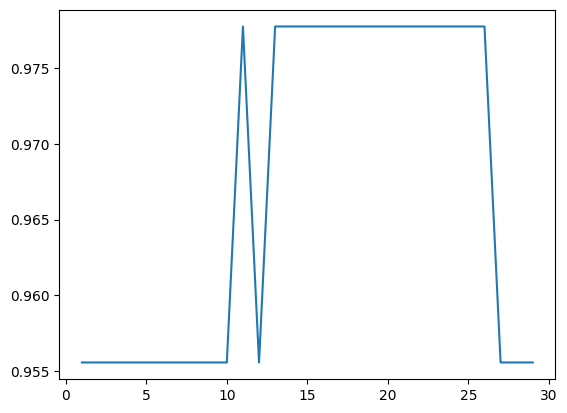

In [23]:
plt.plot(range(1, 30), accuracies)

Почему мы видим такую зависимость?

### Визуализация предсказаний и разделяющих плоскостей

Для ответа на вопрос, произведем визуализацию предсказаний и разделяющих плоскостей. 

Для того, чтобы быстрее и удобнее визуализировать данные на 2D-плоскости, будем пользоваться только двумя последними фичами датасета. 

**Почему именно двумя последними?** Если вернуться выше, то мы можем видеть в документации датасета `iris_dataset.DESCR`, что две последние фичи являются самыми кореллирующимися с нашими целевыми переменными. 

**А почему именно двумя (а не тремя или одним)?** Все просто -- для визуализации на плоскости нам нужно как раз два измерения -- это ось абсцисс и ординат. Разумеется, выбор двух фичей -- не самая лучшая затея (и не самая практичная и широко применимая), поэтому для реальных задач лучше пользоваться методами для понижения размерности (PCA, SVD и др.), но так как у нас самые сильные корелляции уже приходятся на 2 последние фичи -- мы просто можем взять их. 

In [24]:
def get_meshgrid(data, step=.05, border=.5,):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot_decision_surface(estimator, train_data, train_labels, test_data, test_labels):
    colors = ListedColormap(['red', 'blue', 'yellow'])
    light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])
    
    #fit model
    estimator.fit(train_data, train_labels)
    
    #set figure size
    pyplot.figure(figsize = (16, 6))
    
    #plot decision surface on the train data 
    pyplot.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(estimator.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    pyplot.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, cmap=colors)
    pyplot.title('Train data, accuracy={:.4f}'.format(accuracy_score(train_labels, estimator.predict(train_data))))
    
    #plot decision surface on the test data
    pyplot.subplot(1, 2, 2)
    pyplot.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    pyplot.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=100, cmap=colors)
    pyplot.title('Test data, accuracy={:.4f}'.format(accuracy_score(test_labels, estimator.predict(test_data))))

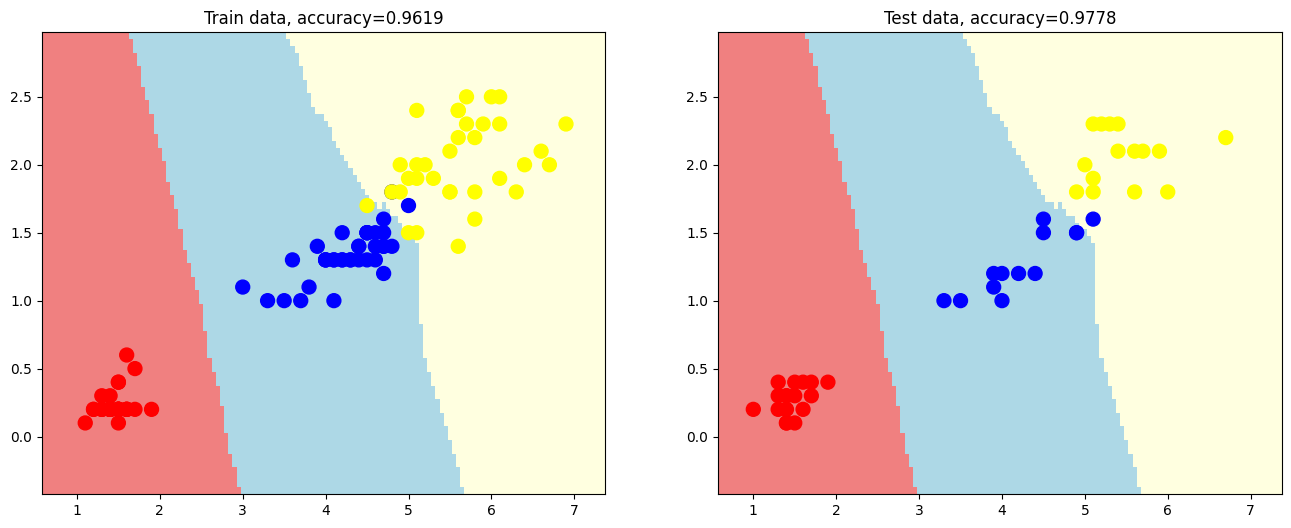

In [25]:
k_neighbours = 5
knn_voting_clf = KNNVotingClassifier(k_neighbours)
plot_decision_surface(knn_voting_clf, X_train[:, 2:], y_train, X_test[:, 2:], y_test)

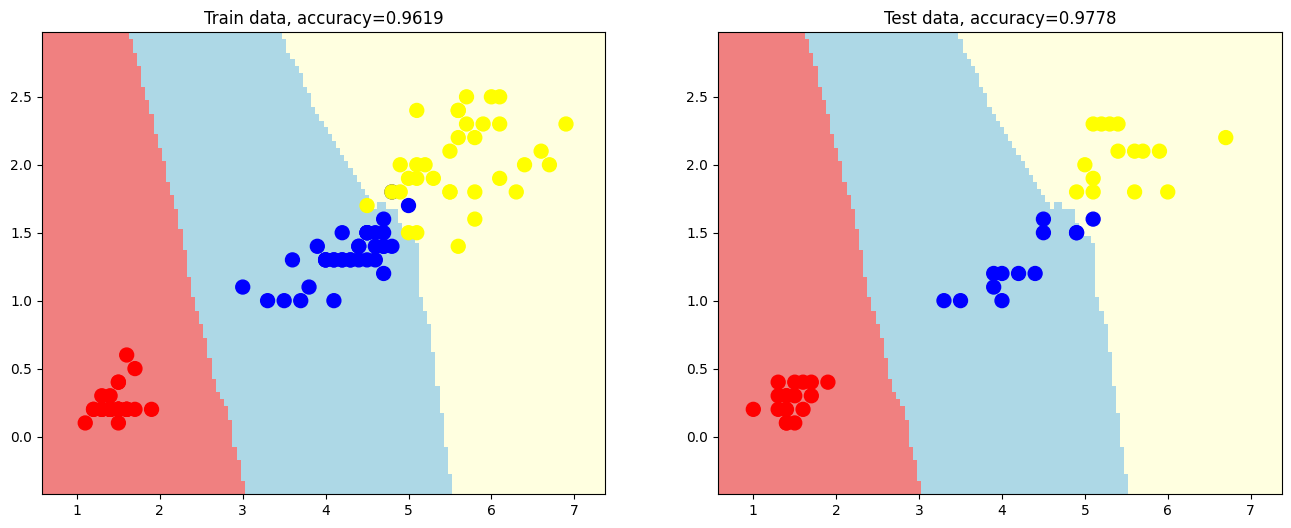

In [26]:
k_neighbours = 6
knn_voting_clf = KNNVotingClassifier(k_neighbours)
plot_decision_surface(knn_voting_clf, X_train[:, 2:], y_train, X_test[:, 2:], y_test)

А теперь резко увеличим количество ближайших соседей. 


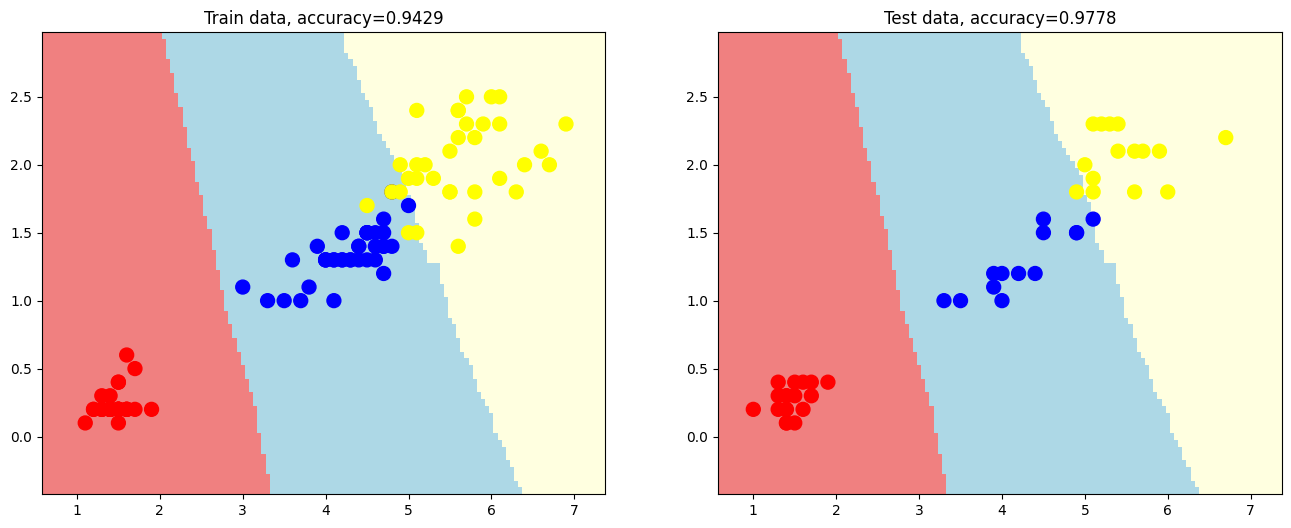

In [27]:
k_neighbours = 35
knn_voting_clf = KNNVotingClassifier(k_neighbours)
plot_decision_surface(knn_voting_clf, X_train[:, 2:], y_train, X_test[:, 2:], y_test)

### Сравнение с sklearn

Проверим, что наша импелементация модели соотносится с имплементацией `KNeighborsClassifier` из `sklearn`. 

In [28]:
sk_knn_clf = KNeighborsClassifier(6, 
                                  metric='euclidean', 
                                  algorithm='brute')
sk_knn_clf.fit(X_train, y_train)

y_pred = sk_knn_clf.predict(X_test)
print('Sklearn kNN Accuracy =', accuracy_score(y_test, y_pred))
print('Sklearn kNN F1-Score =', f1_score(y_test, y_pred, average='micro'))

Sklearn kNN Accuracy = 0.9555555555555556
Sklearn kNN F1-Score = 0.9555555555555556


Видно, что метрики сопоставимы. Проверим теперь корелляцию точности модели с гиперпараметром количества соседей.

In [29]:
accuracies = []
X_train, y_train, X_test, y_test = train_test_split_data(features, target)

for k in range(1, 30):
    knn_voting_clf = KNeighborsClassifier(k, metric='euclidean', algorithm='brute')
    knn_voting_clf.fit(X_train, y_train)
    y_pred = knn_voting_clf.predict(X_test)
    accuracy = np.count_nonzero(y_test == y_pred.squeeze()) / y_test.shape[0]
    accuracies.append(accuracy)

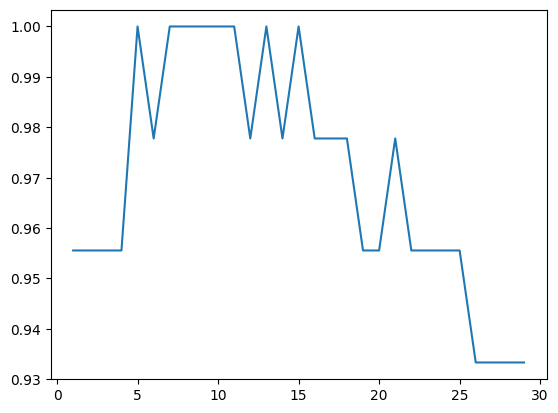

In [30]:
plt.plot(range(1, 30), accuracies)

### Проведем анализ ошибок 

Как ошибки связаны с расстоянием до других объектов класса?

Какая реальная зависимость точности от гиперпараметра `k_neighbours`? Проведите анализ -- почему она такая?

Почему реализация "из коробки" отличается от нашей реализации? Подсказка: посмотрите в [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighbors#sklearn.neighbors.KNeighborsClassifier.kneighbors).

### Practice

Допустим мы хотим модифицировать наш алгоритм так, чтобы объекты, которые находятся рядом с предсказываемым объектом имели больший вес при классификации, чем объекты которые далеки от него. Добавьте  булевый аттрибут **weight_samples** в **KNNClassifier** класс, который сможет учитывать такое поведение. 

Взвешенный KNN метод учитывает не только количество ближайших обьектов но и растояние до них. Есть несколько способов реализации weightedKNN. Воспользуемся наиболее простым: среди ближайших соседей вычислим величины обратные к расстоянию до них  и сложим их для каждой метки. Все значения расстояний положительные, но Некоторые расстояние очень близки к нулю, поэтому во избежание "деления на нуль" проведем "регуляризацию" - добавим к ним небольшую константу (0.1). Это никак не повлияет на соотношение между суммами расстояний, а абсолютные значения этих сумм нас не интересуют. Нам нужно изменить два метода.

**Метод get_nearest_sample**

`KNNWeightClassifier._get_nearest_sample(self, sorted_distances: list) -> int`

Приватный метод, выполняет поиск верного ответа на основе `decision_rule` -- правила для выявления ответа на верный вопрос. 
В этом методе нужно добавить формирование списка distances - расстояния до всх ближайших соседей.

**Метод decision_rule**

`KNNWeightClassifier._decision_rule(labels_top_k: List, distances: List) -> int`

Правило, по которому модель решает, какую метку класса дать семплу, на основе `labels_top_k` -- топ k ближайших меток соседей (в терминах `self._metric`)

В этом методе мы добавили обьект класса Counter чтобы суммировать значения соответствующие каждой метке. И на основе сумм обратных к расстояниям значений возвращать предсказанное значение метки.

In [31]:
class KNNWeightClassifier:
    def __init__(self, 
                 k_neighbours: int, 
                 weight_samples: bool = True, 
                 metric: str = 'euclidean'):
        
        self._allowed_metrics = {
            'euclidean': lambda x, y: numpy_euclidean_norm(x - y),
        }
        
        assert metric in self._allowed_metrics, f"Metric should be one of the {self._allowed_metrics.keys()}, got {metric}"
        
        self._metric = self._allowed_metrics[metric]
        self._k_neighbours = k_neighbours
        self._weight_samples = weight_samples
        
        self._X, self._y = None, None
    
    def fit(self, X: np.array, y: np.array) -> None:
        '''
        When fit() method called -- model just saves the Xs and ys
        '''
        self._X = X
        self._y = y
        
    def predict(self, X: np.array) -> np.array:
        '''Non-optimized version (python loop-based)'''
        
        # Assertion check -- if model is fitted or not
        assert (self._X is not None and self._y is not None), f"Model is not fitted yet!"
        
        ys_pred: np.array = np.zeros(shape=(X.shape[0], 1)) # Predictions matrix allocation
            
        '''
        For each sample in X calculate distances to the points in self._X, using the self._metric()
        calculate distances and get K nearest points. 
        '''
        for sample_id, X_this in enumerate(X):
            distances: List = []
            
            for train_id, X_other in enumerate(self._X):
                distance = self._metric(X_this, X_other)
                distances.append({
                    'train_id': train_id,
                    'distance': distance,
                })
            sorted_distances: List = self._sort_distances(distances)
            y_pred: int = self._get_nearest_class(sorted_distances)
            ys_pred[sample_id] = y_pred

        return ys_pred
     
    @staticmethod
    def _sort_distances(distances: List, ascending=False) -> List:
        return sorted(distances, key=lambda x: x['distance'], reverse=ascending)
    
    def _get_nearest_class(self, sorted_distances: list) -> int:
        ### YOUR CODE HERE...
        # Напишите код для получения топа лейблов и расстояний до каждого из топа лейблов
        sorted_distances_top_k: List = sorted_distances[:self._k_neighbours]
        labels_top_k: List = [self._y[sample['train_id']] for sample in sorted_distances_top_k]
        distances: List = [sample['distance'] for sample in sorted_distances_top_k]
        
        predicted_label = self._decision_rule(labels_top_k, distances)
        return predicted_label
    
    @staticmethod
    def _decision_rule(labels_top_k: List, distances: List) -> int:
        ### YOUR CODE HERE...
        # Напишите код для получения предсказания лейбла
        counter_of_distances = Counter()

        for i in range(len(labels_top_k)):
            counter_of_distances.update({labels_top_k[i]:1/(distances[i]+0.1)} )

        # print(counter_of_distances)

        predicted_label  = max(zip(counter_of_distances.values(), counter_of_distances.keys()))[1]

        return predicted_label

Сравним результаты простого и взвешенного KNN способа. На нашей тестовой выборке результаты практически не отличаются. Но на большей выборке точность взвешенного метода несколько выше. 

In [32]:
k_neighbours = 5

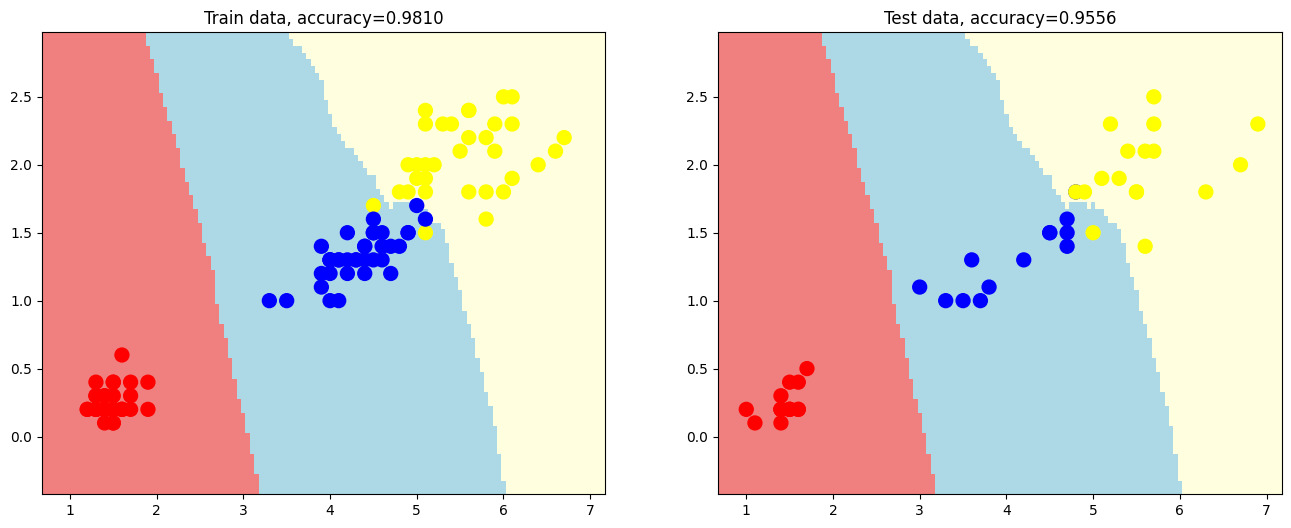

In [33]:

knn_voting_clf = KNNWeightClassifier(k_neighbours)
plot_decision_surface(knn_voting_clf, X_train[:, 2:], y_train, X_test[:, 2:], y_test)

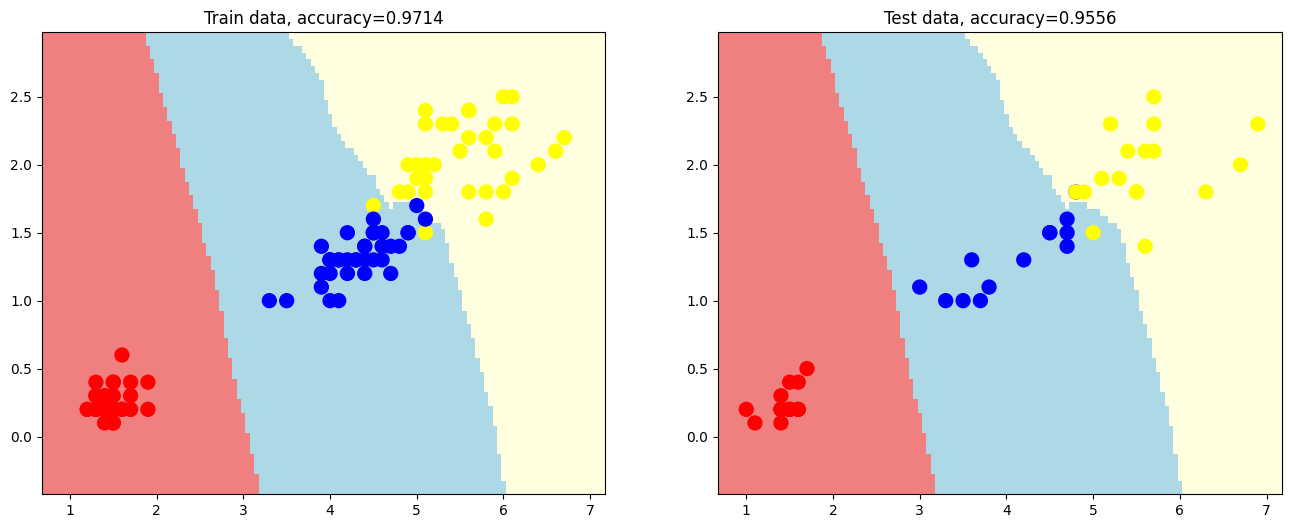

In [34]:

knn_voting_clf = KNNVotingClassifier(k_neighbours)
plot_decision_surface(knn_voting_clf, X_train[:, 2:], y_train, X_test[:, 2:], y_test)

## Practice со звездочкой*

Предположим, что мы хотим выкатить нашу модельку в прод. 

Пускай теперь нам нужно выяснить, как долго будет выполняться одна итерация предсказания (будем считать, что на обучения у нас не уходит времени, т.к. эта операция выполняется за `О(1)`.

Сделаем это: 

In [35]:
def test_custom():
    knn_clf =  KNNVotingClassifier(6)
    knn_clf.fit(X_train, y_train)
    knn_clf.predict(X_test)
    
%timeit -r 4 -n 3000 test_custom()

6.37 ms ± 91.3 µs per loop (mean ± std. dev. of 4 runs, 3,000 loops each)


Видим, что в среднем одна итерация занимает 8.45 миллисекунд. Кажется, что неплохо... Но правда ли неплохо?..

Сравнимся с `sklearn`.

In [36]:
def test_sklearn():
    knn_clf =  KNeighborsClassifier(6)
    knn_clf.fit(X_train, y_train)
    knn_clf.predict(X_test)

%timeit -r 4 -n 3000 test_sklearn()

852 µs ± 1.8 µs per loop (mean ± std. dev. of 4 runs, 3,000 loops each)


На первый взгляд могло показаться, что наше решение даже быстрее, чем коробочное, но, если посмотреть внимательнее, то видно, что решение из sklearn работает за **МИКРОСЕКУНДЫ**. Наше же решение дольше на целые порядки.

Поэтому, нужно это исправлять.

Как выше выяснилось, наша реализация является не самой эффективной в плане скорости выполнения и используемой памяти. 

С помощью [numpy broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) и векторизации вычислимых функций в `numpy`, сделайте реализацию нашего метода `predict()` более эффективной и быстрой. 

Это может потребовать изменение архитектуры и изменения реализации метода `predict()` полностью.

Для простоты, можно ужать функционал и оставить только одну метрику, так как иначе реализация кода для нескольких метрик, или тем более в общем случае для любой кастомной метрики расстояния, сделает решение слишком громоздким и сложным для понимания.

В качестве датасета выберите датасет MNIST, а в качестве метрики используйте метрику Фробениуса (Фробениусову норму).

Выпонение ДЗ

будем загружать файлы MNIST из файлов CSV. А при обработке используем метод cdist из библиотеки SCIPY
Отдельно загрузим тренинговый файл, отдельно тестовый

In [8]:

from numpy import genfromtxt
from numpy import newaxis

from scipy.spatial.distance import cdist as distances

Загрузка файлов. Файлы должны быть расположены в одной директории с программой

In [9]:
train_data = genfromtxt('mnist_train.csv', delimiter=',')

test_data = genfromtxt('mnist_test.csv', delimiter=',' )

Преобразуем массивы полученные из файлов на два массива: метки и сами данные

Labels_train, Data_train
Labels_test, Data_test

In [13]:
Data_train = train_data[1:,1:]

Labels_train = np.reshape(train_data[1:,:1],len(train_data)-1)

Data_test = test_data[1:,1:]

Labels_test = np.reshape(test_data[1:,:1],len(test_data)-1)


Перепишем класс OptimizedKNNClassifier

Метод fit оставим без изменений.
Полностью перепишем метод predict. Не будем выделять в нем функции, а опишем высю процедуру предсказания в одном методе.
Каждая "цифра" представлена в наших массивах вектором из 784 значений типа byte. в массиве Data_train 60К значений, в массиве Data_test 10К значений. Нам необходимо вычислить расстояние (фробениусову (в нашем случае евклидову) норму) между каждым из элементов массива Data_test и всеми элементами массива Data_train. Если делать эту процедуру в цикле, то она будет неэффективна по времени. При попытке реализовать эту процедуру с использованием библиотеки numpy система не смогла обработать матрицу 60К*10К значений и выпадала по ошибке "нехватка памяти". Обработать такую матрицу целиком смогла библиотека scipy.
Функция scipy.spatial.distance.cdist. Она возвращает матрицу расстояний (Distances) между каждым из элементов массива Data_test и всеми элементами массива Data_train. Вычислние этой матрицы на моем компьютере заняло 211 секунд. 

После этого необходимо провести сортировку каждой строки матрицы Distances, соответствующей каждому элементу теста, выбрать заданное количество ближайших соседей и определить класс к которому принадлежит этот тестовый вектор.

Эти процедуры реализованы с помощью обьекта класса Counter, метода argsort библиотеки numpy и метода most_common коасса Counter.

In [14]:
### YOUR CODE HERE...
### YOUR CODE HERE...

class OptimizedKNNClassifier:
    def __init__(self, 
                 k_neighbours: int, 
                 weight_samples: bool = False, 
                 metric: str = 'euclidean'):
        
        self._allowed_metrics = {
            'euclidean': lambda x, y: numpy_euclidean_norm(x - y),
        }
        
        assert metric in self._allowed_metrics, f"Metric should be one of the {self._allowed_metrics.keys()}, got {metric}"
        
        self._metric = self._allowed_metrics[metric]
        self._k_neighbours = k_neighbours
        self._weight_samples = weight_samples
        
        self._Data_train, self._Labels_train = None, None
    
    def fit(self, X: np.array, y: np.array) -> None:
        '''
        When fit() method called -- model just saves the Xs and ys
        '''
        self._Data_train = X
        self._Labels_train = y
        
    def predict(self,  _Data_test: np.array, _Labels_test: np.array) -> np.array:
        '''Non-optimized version (python loop-based)'''
        
        # Assertion check -- if model is fitted or not
        # assert (self._X is not None and self._y is not None), f"Model is not fitted yet!"

        Distances = distances(_Data_test, self._Data_train)
        
        Result = np.zeros(len(_Labels_test))

        for i in range(len(Distances)):
            Y = np.column_stack([self._Labels_train, Distances[i]])

            X = Y[np.argsort(Y[:, 1])]

            W = X[:self._k_neighbours]

            Result[i] = Counter(W[:,0]).most_common(1)[0][0]

        return Result

In [20]:
knn_optim =  OptimizedKNNClassifier(6)
knn_optim.fit(Data_train, Labels_train)
Result = knn_optim.predict(Data_test, Labels_test)

сравнение производительности надо проводить на массивах меньшей размерности


In [18]:
small_train_array = 10000
small_test_array = 50

knn_optim =  OptimizedKNNClassifier(6)
knn_optim.fit(Data_train[:small_train_array], Labels_train[:small_train_array] )
Result = knn_optim.predict(Data_test[:small_test_array], Labels_test[:small_test_array])

Err = np.count_nonzero(Result - Labels_test[:small_test_array])

Err/len(Result)

Вычислим ошибку как количество ненулевых результатов в разности реальных результатов и оценки. и возьмем отношение к общему количеству результатов.

In [19]:
Err = np.count_nonzero(Result - Labels_test[:small_test_array])

Err/len(Result)

0.04